# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.append("..")
from helpers import filename_for

Welcome to JupyROOT 6.16/00


## Example Fit / Calibration

In [2]:
label = "nPN"

In [3]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.pkl") for n in [1, 2, 3, 4, 5] for s in range(20)
]
dfs = [pd.read_pickle(file) for file in files]
data = pd.concat(dfs, ignore_index=True)

In [5]:
msk = np.random.rand(len(data)) < 0.8
msk[0] = True
msk[1] = False
data.loc[0] = data.loc[1] = [0, 0, 0, 0, 0, 0]

traindata = data[msk].sample(frac=1)
testdata = data[~msk].sample(frac=1)

In [6]:
model = Bayes(traindata, 5, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(2, 2), (1, 0), (3, 4), (4, 5), (3, 3), (4, 5), (1, 1), (5, 4), (2, 2), (5, 5), (5, 5), (2, 1), (1, 2), (4, 4), (1, 1), (1, 1), (2, 2), (5, 5), (3, 4), (1, 1), (5, 5), (2, 2), (4, 4), (2, 2), (3, 3), (2, 2), (1, 1), (1, 1), (4, 3), (1, 1), (5, 4), (2, 2), (2, 2), (4, 4), (5, 5), (4, 3), (5, 5), (5, 5), (4, 4), (2, 3), (3, 4), (1, 1), (4, 3), (1, 1), (3, 2), (5, 5), (4, 4), (3, 5), (2, 3), (4, 4)]


## Example Prediction

In [7]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

0.6768019340768584
[[    1     0     0     0     0     0]
 [ 1955 33173  4501    31     3     4]
 [  106  7681 24392  7743   202     4]
 [    6  1166  9021 19786  9202   706]
 [    2   138  1891  9530 17344 11047]
 [    4    10   342  2597  9515 27302]]
[[1.    0.    0.    0.    0.    0.   ]
 [0.049 0.836 0.113 0.001 0.    0.   ]
 [0.003 0.191 0.608 0.193 0.005 0.   ]
 [0.    0.029 0.226 0.496 0.231 0.018]
 [0.    0.003 0.047 0.239 0.434 0.277]
 [0.    0.    0.009 0.065 0.239 0.686]]


Text(69.0, 0.5, 'True')

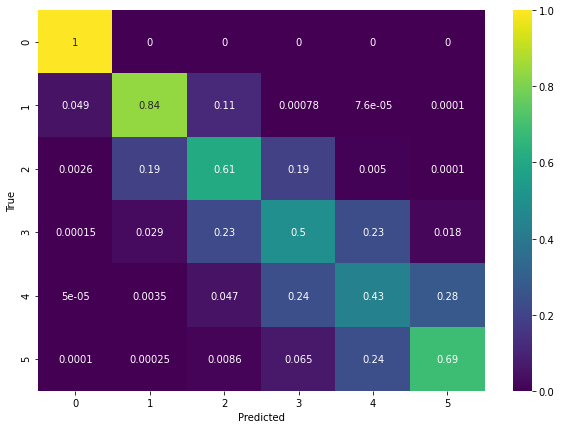

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [9]:
for n in [1, 2, 3, 4, 5]:
    subset = data[data[label] <= n]
    msk = np.random.rand(len(subset)) < 0.8
    msk[0] = True
    msk[1] = False
    traindata = subset[msk].sample(frac=1)
    testdata = subset[~msk].sample(frac=1)

    model = Bayes(traindata, n, label)
    y_pred = model.predict(testdata)
    y_true = testdata[label].values.ravel()
    #print(list(zip(y_true, y_pred))[0:50])
    bac = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
    print(cm)
    print(n, bac)

[[    1     0]
 [ 1868 38106]]
1 0.9766348126282083
[[    1     0     0]
 [ 1981 33408  4662]
 [   99  7701 32305]]
2 0.8798823369463794
[[    1     0     0     0]
 [ 1924 33462  4554    39]
 [   87  7664 24394  7912]
 [    8  1220  9181 29813]]
3 0.7967957243050154
[[    1     0     0     0     0]
 [ 2016 33207  4539    32     7]
 [   78  7859 23854  7737   225]
 [    7  1149  8958 19793  9764]
 [    4   133  1823  9349 28485]]
4 0.7298242459531441
[[    1     0     0     0     0     0]
 [ 1957 33545  4499    31     3     5]
 [   77  7902 24266  7712   232     7]
 [    6  1201  9035 19757  9169   706]
 [    1   137  1990  9661 17463 11204]
 [    1    14   325  2584  9610 27451]]
5 0.6758585825131064
